In [3]:
"""
Demo model - so there is a lot of code that was left commented out during development.
Update file locations to match where you generated data.  

Test data will be required from the generator to train.
"""

'\nDemo model - so there is a lot of code that was left commented out during development.\nUpdate file locations to match where you generated data.  \n\n\n'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INPUT PIPELINE

In [ ]:
"""
Update the file locations to where your training data is located
"""

# get data files

train_x = np.load('/content/drive/MyDrive/framebot/data/train_input.npy', allow_pickle=True)
train_y = np.load('/content/drive/MyDrive/framebot/data/train_label.npy', allow_pickle=True)

val_x = np.load('/content/drive/MyDrive/framebot/data/val_input.npy', allow_pickle=True)
val_y = np.load('/content/drive/MyDrive/framebot/data/val_label.npy', allow_pickle=True)

test_x = np.load('/content/drive/MyDrive/framebot/data/test_input.npy', allow_pickle=True)
test_y = np.load('/content/drive/MyDrive/framebot/data/test_label.npy', allow_pickle=True)


In [ ]:
# normalize the data
train_x = train_x / 2
val_x = val_x / 2
test_x = test_x / 2

In [ ]:
# flatten the data
def flatten_data(data):
    flat_data = []
    for i in data:
        flat_data.append(i.flatten())

    return flat_data

In [ ]:
train_x_ = flatten_data(train_x)
train_y_ = flatten_data(train_y)

val_x_ = flatten_data(val_x)
val_y_ = flatten_data(val_y)

test_x_ = flatten_data(test_x) 
test_y_ = flatten_data(test_y)

In [ ]:
# Hyper parameters
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 1024
BUFFER_SIZE = 400000

STEPS_PER_EPOCH = len(train_x_) // BATCH_SIZE
VALID_STEPS = len(val_x_) // BATCH_SIZE

train_steps = len(train_x_) // BATCH_SIZE

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x_, train_y_))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x_, val_y_))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x_, test_y_))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 1050), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1620), dtype=tf.float32, name=None))

In [ ]:
val_dataset.element_spec

(TensorSpec(shape=(None, 1050), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1620), dtype=tf.float32, name=None))

In [ ]:
test_dataset.element_spec

(TensorSpec(shape=(None, 1050), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1620), dtype=tf.float32, name=None))

MODEL

In [ ]:
with tpu_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1050,)),
        # unit 0
        tf.keras.layers.Dense(2048, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        # unit 1
        tf.keras.layers.Dense(2048, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        # unit 2
        tf.keras.layers.Dense(2048, activation='elu'),
        
        tf.keras.layers.Dense(1620, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
EPOCHS = 100

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

In [ ]:
# save the model
# model.save('/content/drive/MyDrive/framebot/model/V1.01/model.h5')

In [ ]:
# reconstructed_model = tf.keras.models.load_model('/content/drive/MyDrive/framebot/model/V1.01/model.h5')

In [ ]:
#reconstructed_model.summary()

In [ ]:
"""
history = reconstructed_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
"""

'\nhistory = reconstructed_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)\nfinal_accuracy = history.history["val_accuracy"][-5:]\nprint("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))\n'

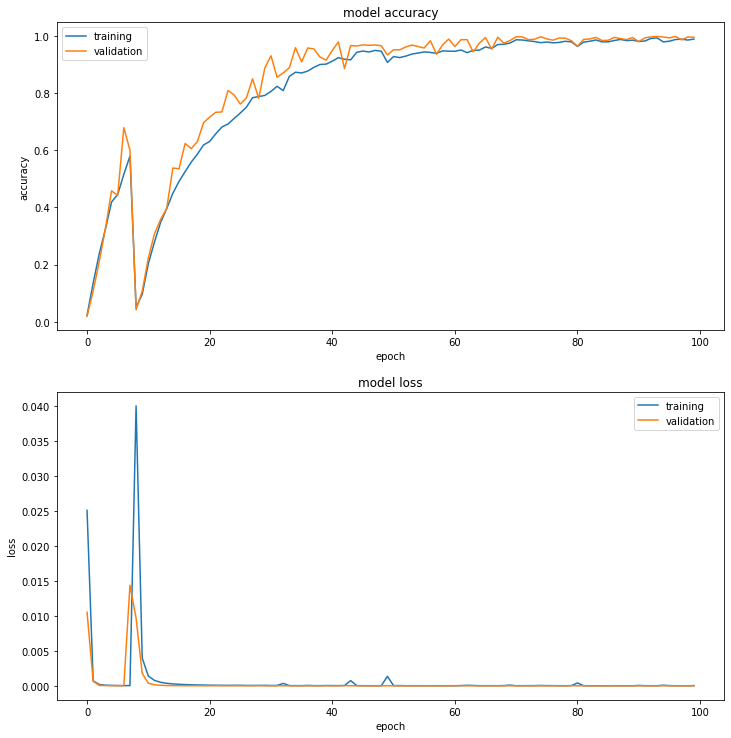

In [ ]:
def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# load model
model = tf.keras.models.load_model('/content/drive/MyDrive/framebot/model/V1.01/model.h5')

In [ ]:
# evaluate
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 52ms/step - loss: 3.6426e-07 - accuracy: 0.9965
